In [1]:
!pip install -q pydicom numpy matplotlib Pillow
import os
import cv2
import numpy as np
import pydicom
from PIL import Image
import matplotlib.pyplot as plt

import torch
import pandas as pd
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torch import optim
import random

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from scipy.ndimage import zoom
from concurrent.futures import ThreadPoolExecutor

def process_dicom_file(dicom_name, patient_data):
  dcm = pydicom.dcmread(dicom_name, force=True)
  img = dcm.pixel_array
  img -= np.min(img)      # Normalize image
  img = img / np.max(img) #
  if len(patient_data["imgs"]) == 0:
    patient_data["imgs"] = np.array(img, dtype="float32")
  else:
    patient_data["imgs"] = np.dstack((patient_data["imgs"], img))
  age = int(dcm.PatientAge[:-1])
  patient_data["age"] = age

## self.data contains all patient directories where each index is: key "img" with all images, and key "age" with age
class NewDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.patient_dirs = os.listdir(root_dir)
    self.transform = transform
    self.width = 128
    self.height = 128
    self.depth = 64
    self.data = []
    for i, dir in enumerate(self.patient_dirs):
      subdir_path = os.path.join(root_dir, dir)
      dicom_files = os.listdir(subdir_path)
      dicom_arr = np.zeros(len(dicom_files))
      patient_data = {"imgs": [], "age": 0}

      with ThreadPoolExecutor(max_workers=min(len(dicom_files), 240)) as executor:
        futures = [executor.submit(process_dicom_file, os.path.join(subdir_path, dicom_file), patient_data) for dicom_file in dicom_files]
        for future in futures:
          future.result()

      # Reshape to shape (128, 128, 64)
      width_factor = self.width / patient_data["imgs"].shape[0]
      height_factor = self.height / patient_data["imgs"].shape[1]
      depth_factor = self.depth / patient_data["imgs"].shape[2]
      patient_data["imgs"] = zoom(patient_data["imgs"], (width_factor, height_factor, depth_factor), order=1)
      self.data.append(patient_data)

  def __len__(self):
    return len(self.patient_dirs)

  def __getitem__(self, idx):
    patient_data = self.data[idx]
    imgs = patient_data["imgs"]
    imgs = torch.from_numpy(imgs).float()
    age = patient_data["age"]

    # Apply windowing
    window_min = -1000
    window_max = 300
    imgs = (imgs - window_min) / (window_max - window_min)
    imgs = imgs.clamp(0, 1)

    if self.transform:
      imgs = self.transform(imgs)

    return imgs, age

In [4]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5)
])
patient_dataset = NewDataset(root_dir="/content/drive/MyDrive/Kaggle_Proj/Experiment_Dataset_Smaller/", transform=transform)

In [5]:
for sample in patient_dataset:
  X, y = sample
  print(X.shape)
  print(y)
  break

torch.Size([128, 128, 64])
44


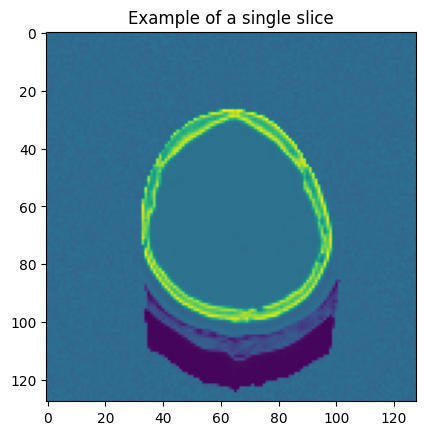

In [6]:
# Plot sample slice
plt.imshow(X[:, :, 0])
plt.title("Example of a single slice")
plt.show()

In [7]:
train_set, test_set = random_split(patient_dataset, [0.8, 0.2])
train_dataloader = DataLoader(train_set, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=1)
print(f"Train set size: {len(train_set)}, Test set size: {len(test_set)}")

Train set size: 52, Test set size: 12


In [8]:
for X, y in train_dataloader:
  print(X.shape)
  print(y)
  break

torch.Size([1, 128, 128, 64])
tensor([26])


In [9]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"Using device: {device}")

Using device: cpu


In [10]:
import torchvision.models as models

pretrained_model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

for param in pretrained_model.parameters():
  param.requires_grad = False

In [59]:
import torch.nn as nn
# --- Model Architecture ---
#
# CNN Model for age prediction task
# Input: Tensors representing images
# Output: Integer representing age
#
# We use a number of convolutional layers to downsample the images
# Then we flatten the outputs from convolutional layers and run them
# through a number of dense layers to finally get a single number as output
#
torch.set_default_dtype(torch.float32)

class Attention(nn.Module):
  def __init__(self, d_size):
    super().__init__()
    self.Q = nn.Linear(d_size, d_size)
    self.K = nn.Linear(d_size, d_size)
    self.V = nn.Linear(d_size, d_size)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    Q = self.Q(x)
    K = self.K(x)
    V = self.V(x)
    d = K.shape[1]
    Y = self.softmax((Q @ torch.transpose(K, 1, 2)) / d) @ V

    return Y

class CNN_model(nn.Module):
  def __init__(self, pretrained_model):
    super().__init__()
    self.img_size = 128
    self.channels = 64
    self.hidden_units = 32

    self.pre_conv = nn.Conv2d(in_channels=self.channels, out_channels=3, kernel_size=3, stride=2)
    self.pretrained_model = pretrained_model
    self.pretrained_model.classifier = nn.Identity()

    self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv_layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.Mish()
    )
    self.conv_layer2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=12, kernel_size=3, stride=1, padding=1),
        nn.Mish()
    )
    self.attention_2 = Attention(12)
    self.layer_norm_2 = nn.LayerNorm([12, 12, 12])
    self.dense_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=12*12*12, out_features=1)
    )


  def forward(self, x):
    x = x.permute(0, 3, 1, 2)

    x = self.pre_conv(x)
    x = x.relu()
    x = self.pretrained_model(x)
    x = x.unsqueeze(0)
    x = x.reshape(1, int(np.sqrt(x.shape[2])), int(np.sqrt(x.shape[2])))
    x = self.conv_layer1(x)
    x = self.max_pool(x)
    x = self.conv_layer2(x)
    x = self.attention_2(x)
    x = self.layer_norm_2(x)
    x = x.unsqueeze(0)
    x = self.dense_layer(x)

    return x

model = CNN_model(pretrained_model)
model.to(device)

CNN_model(
  (pre_conv): Conv2d(64, 3, kernel_size=(3, 3), stride=(2, 2))
  (pretrained_model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
       

In [60]:
for X, y in train_dataloader:
  X, y = X.to(device), y.to(device)
  print(f"Input format: {X.shape}")
  out = model(X)
  print(f"Target shape: {y.shape}, Output shape: {out.shape}")
  break

Input format: torch.Size([1, 128, 128, 64])
Target shape: torch.Size([1]), Output shape: torch.Size([1, 1])


In [61]:
# Training run
import gc
num_epochs = 140
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=2e-3)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=1e-5, total_iters=100)

def train():
  model.train()
  train_loss = 0
  for X, y in train_dataloader:
    X, y = X.to(device), y.to(device)
    output = model(X)
    loss = loss_fn(output, y.unsqueeze(0))
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  scheduler.step()
  train_loss /= len(train_dataloader)
  return train_loss

def test():
  model.eval()
  test_loss = 0
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    pred = model(X)
    test_loss += loss_fn(pred, y.unsqueeze(0))
  test_loss /= len(test_dataloader)
  return test_loss

train_losses = []
test_losses = []
final_loss = 0
jdx = 0
for epoch in range(num_epochs):
  train_loss = train()
  test_loss = test()
  train_losses.append(train_loss.detach().cpu())
  test_losses.append(test_loss.detach().cpu())
  if (epoch + 1) > num_epochs - 20:
    final_loss += test_loss
    jdx += 1
  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch + 1}, Training loss: {train_loss:.4f}, Test loss: {test_loss:.4f}")
  gc.collect()

Epoch: 10, Training loss: 20.4888, Test loss: 10.3478
Epoch: 20, Training loss: 10.5627, Test loss: 10.2034
Epoch: 30, Training loss: 13.0042, Test loss: 9.4680
Epoch: 40, Training loss: 11.9901, Test loss: 8.4796
Epoch: 50, Training loss: 12.9539, Test loss: 9.4340
Epoch: 60, Training loss: 10.4920, Test loss: 10.4854
Epoch: 70, Training loss: 10.1085, Test loss: 9.1148
Epoch: 80, Training loss: 10.5667, Test loss: 8.7341
Epoch: 90, Training loss: 9.7647, Test loss: 8.4576
Epoch: 100, Training loss: 9.7059, Test loss: 8.4167
Epoch: 110, Training loss: 9.6739, Test loss: 8.3728
Epoch: 120, Training loss: 9.6738, Test loss: 8.4489
Epoch: 130, Training loss: 9.6738, Test loss: 8.4883
Epoch: 140, Training loss: 9.6737, Test loss: 8.3784


In [62]:
for X, y in test_dataloader:
  X, y = X.to(device), y.to(device)
  out = model(X)
  print("Example prediction")
  print(f"Prediction: {out.item():.0f}, correct: {y.item()}")
  break

Example prediction
Prediction: 37, correct: 39


In [63]:
print(f"Final test loss: {final_loss / jdx}")

Final test loss: 8.434090614318848


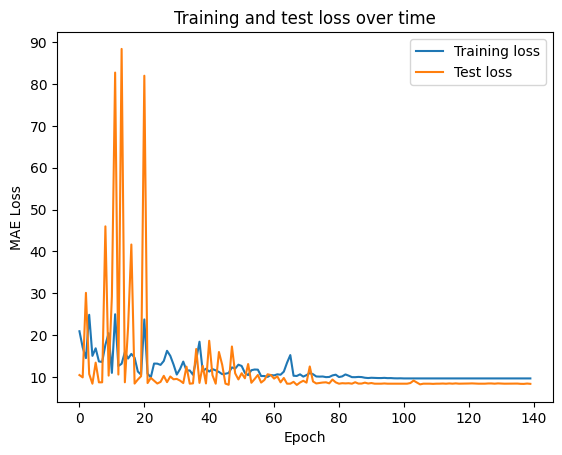

In [64]:
# Plot training and test losses
plt.plot(range(num_epochs), train_losses, label="Training loss")
plt.plot(range(num_epochs), test_losses, label="Test loss")
plt.title("Training and test loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.show()

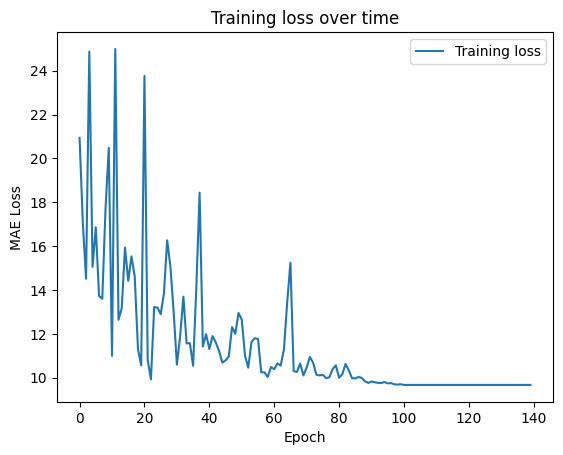

In [65]:
# Plot training and test losses
plt.plot(range(num_epochs), train_losses, label="Training loss")
plt.title("Training loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.show()

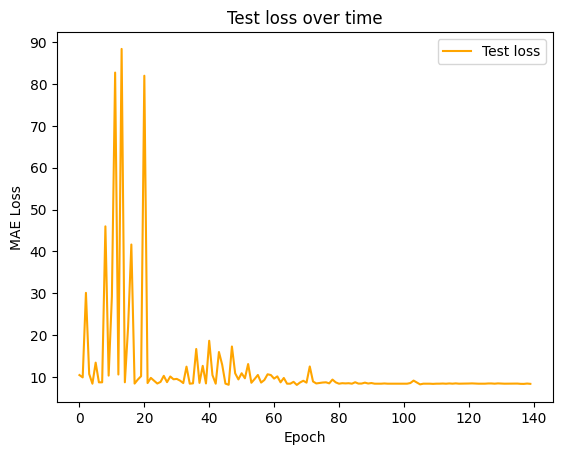

In [66]:
plt.plot(range(num_epochs), test_losses, "orange", label="Test loss")
plt.title("Test loss over time")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.legend()
plt.show()